# Challenge:
The problem consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile (SCL). For that you will have a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL during 2017. The following information is available for each flight:
Fecha-I: Scheduled date and time of the flight.
Vlo-I : Scheduled flight number.
Ori-I : Programmed origin city code.
Des-I : Programmed destination city code.
Emp-I : Scheduled flight airline code.
Fecha-O : Date and time of flight operation.
Vlo-O : Flight operation number of the flight.
Ori-O : Operation origin city code
Des-O : Operation destination city code.
Emp-O : Airline code of the operated flight.
DIA: Day of the month of flight operation.
MES : Number of the month of operation of the flight.
AÑO : Year of flight operation.
DIANOM : Day of the week of flight operation.
TIPOVUELO : Type of flight, I =International, N =National.
OPERA : Name of the airline that operates.
SIGLAORI: Name city of origin.
SIGLADES: Destination city name.

## Challenge
1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?
2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:
○ high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
○ min_diff : difference in minutes between Date-O and Date-I .
○ delay_15 : 1 if min_diff > 15, 0 if not.
○ period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I .
3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?
What variables would you expect to have the most influence in predicting delays?
4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables.
5. Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used
to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in
the prediction task? How could you improve the
Performance?

## Additional aspects to consider in the evaluation
Order and clarity when proposing an analysis, idea, code, etc.
Creativity to solve the challenge.
Versioned code in Git.
We are not going to review excel, macros, R codes.
We will not review challenges that do not arrive on the indicated date
When in doubt, make your assumptions explicit.
Try to express yourself as best as possible to explain your decisions and answers.

# Solution starting point

in this notebook i will develop a model that predicts the probability of delay of the flights that land or take off from the SCL airport.
For this, we have a dataset called "dataset_SCL.csv", the porpuse is to obtain all the questions above and be very clear on the various steps needed to build this. There will be **important** concepts and steps, like the EDA steps, separation of the dataset in the training stage, making cross-validation to determine accurate model parameters.

For this, python gives us tools to acomplish this with:
- data manipulation: pandas, numpy
- dataviz: matplolib, seaborn, basemap
- modeling: sklearn, scipy
- class definition: regression, figures


As a data scientist, I will create good quality figures to divulgate the findings considering that the reader do not necessarily have knowledge in the techical aspects of data science.

Also, I will consider classes or functions embeded in loops just for lees number of lines of code to reduce the opportunities to make mistakes.

So let get started by loading all the packages that we will need:

In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

now I read the file that contains the details of all the flights that occured in 2017 SCL. I output some informations concerning the types of the variables in the dataframe and the quantity of null values for each variable:
I will output information regarding to:
- variables
- null's
- uniques

In [70]:
df = pd.read_csv('C:/Users/ancaro/airlinedelay/dataset_SCL.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

# Get the number of unique values for each column
unique_counts = df.nunique()

# Calculate the percentage of unique values for each column
percentage_unique = (unique_counts / df.shape[0]) * 100

# Create a DataFrame to display the information
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'column type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum() / df.shape[0] * 100).T.rename(index={0: 'null values (%)'}))
tab_info = tab_info.append(pd.DataFrame(unique_counts).T.rename(index={0: 'unique values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(percentage_unique).T.rename(index={0: 'unique values (%)'}))

print(tab_info)


Dataframe dimensions: (68206, 18)
                      Fecha-I    Vlo-I     Ori-I     Des-I     Emp-I  \
column type            object   object    object    object    object   
null values (nb)            0        0         0         0         0   
null values (%)           0.0      0.0       0.0       0.0       0.0   
unique values (nb)      53252      584         1        64        30   
unique values (%)   78.075243  0.85623  0.001466  0.093833  0.043984   

                      Fecha-O     Vlo-O     Ori-O     Des-O     Emp-O  \
column type            object    object    object    object    object   
null values (nb)            0         1         0         0         0   
null values (%)           0.0  0.001466       0.0       0.0       0.0   
unique values (nb)      62774       861         1        63        32   
unique values (%)   92.035891  1.262352  0.001466  0.092367  0.046917   

                         DIA       MES       AÑO    DIANOM TIPOVUELO  \
column type           

We have:
Fecha-I: Scheduled date and time of the flight.
Vlo-I : Scheduled flight number.
Ori-I : Programmed origin city code.
Des-I : Programmed destination city code.
Emp-I : Scheduled flight airline code.
Fecha-O : Date and time of flight operation.
Vlo-O : Flight operation number of the flight.
Ori-O : Operation origin city code
Des-O : Operation destination city code.
Emp-O : Airline code of the operated flight.
DIA: Day of the month of flight operation.
MES : Number of the month of operation of the flight.
AÑO : Year of flight operation.
DIANOM : Day of the week of flight operation.
TIPOVUELO : Type of flight, I =International, N =National.
OPERA : Name of the airline that operates.
SIGLAORI: Name city of origin.
SIGLADES: Destination city name.


considering that python can manage dates, all the date variables will be formated to date data type. First, we will see a glimpse of the date variables to see how they're written and format them correctly

1. Cleaning
1.1 the df have time variables: ['Fecha-I', 'Fecha-O', 'DIA', 'MES', 'AÑO', 'DIANOM'], and we need to format them to a date format to handle them.

In [47]:
date_columns = ['Fecha-I', 'Fecha-O', 'DIA', 'MES', 'AÑO', 'DIANOM']


date_preview = df[date_columns].head()

print(date_preview)

               Fecha-I              Fecha-O  DIA  MES   AÑO     DIANOM
0  2017-01-01 23:30:00  2017-01-01 23:33:00    1    1  2017    Domingo
1  2017-01-02 23:30:00  2017-01-02 23:39:00    2    1  2017      Lunes
2  2017-01-03 23:30:00  2017-01-03 23:39:00    3    1  2017     Martes
3  2017-01-04 23:30:00  2017-01-04 23:33:00    4    1  2017  Miercoles
4  2017-01-05 23:30:00  2017-01-05 23:28:00    5    1  2017     Jueves


let's format the date variables:

In [48]:
date_columns = ['Fecha-I', 'Fecha-O']

# Convert the date-like columns to datetime format
df[date_columns] = df[date_columns].apply(pd.to_datetime)

# Display the first few rows of the date columns with the new datetime format
date_preview = df[date_columns].head()

print(date_preview)


              Fecha-I             Fecha-O
0 2017-01-01 23:30:00 2017-01-01 23:33:00
1 2017-01-02 23:30:00 2017-01-02 23:39:00
2 2017-01-03 23:30:00 2017-01-03 23:39:00
3 2017-01-04 23:30:00 2017-01-04 23:33:00
4 2017-01-05 23:30:00 2017-01-05 23:28:00


In [49]:
print(df.dtypes)

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object


1.2 Data completion

In [50]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Vlo-O,1,99.998534
1,Fecha-I,0,100.000000
2,OPERA,0,100.000000
3,TIPOVUELO,0,100.000000
4,DIANOM,0,100.000000
5,AÑO,0,100.000000
6,MES,0,100.000000
7,DIA,0,100.000000
8,Emp-O,0,100.000000
9,Des-O,0,100.000000


we see a really good filling factor, so the missing value will be dropped

In [51]:
df.dropna(inplace = True)

we saw that we have 23 OPERATORS, we will see them

In [52]:
OPERATORS = df['OPERA'].unique()
OPERATORS

array(['American Airlines', 'Air Canada', 'Air France', 'Aeromexico',
       'Aerolineas Argentinas', 'Austral', 'Avianca', 'Alitalia',
       'British Airways', 'Copa Air', 'Delta Air', 'Gol Trans', 'Iberia',
       'K.L.M.', 'Qantas Airways', 'United Airlines', 'Grupo LATAM',
       'Sky Airline', 'Latin American Wings', 'Plus Ultra Lineas Aereas',
       'JetSmart SPA', 'Oceanair Linhas Aereas', 'Lacsa'], dtype=object)

2. Statistical description of airlines
for this, we will create a collumn called DELAY that will be the difference of "Fecha-I" and "Fecha-O"

DELAY = "Fecha-O" - "Fecha-I"

In [53]:
df['DELAY'] = ((df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60).astype(int)

df


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,DELAY
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,3
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,9
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,9
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,3
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,46
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima,16
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima,40
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,13


Now we will see basic statistical information about the delay by operator

In [54]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DELAY'].groupby(df['Emp-O']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
Emp-O,,,,
TPU,116.0,120.0,2.0,118.000000
48O,0.0,46.0,10.0,11.400000
56R,0.0,93.0,16.0,39.937500
PUE,-9.0,157.0,49.0,31.714286
AUT,-14.0,125.0,77.0,9.012987
QFA,-7.0,159.0,195.0,26.835897
BAW,-11.0,124.0,205.0,7.560976
LAP,-7.0,111.0,219.0,12.484018
KLM,-14.0,161.0,251.0,1.310757


2.1 Dataviz statistical information of delays
lets create a dictionary where [OPERA: Emp-O]

In [55]:
operadict = dict(zip(df['Emp-O'], df['OPERA']))
len(operadict)

32

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

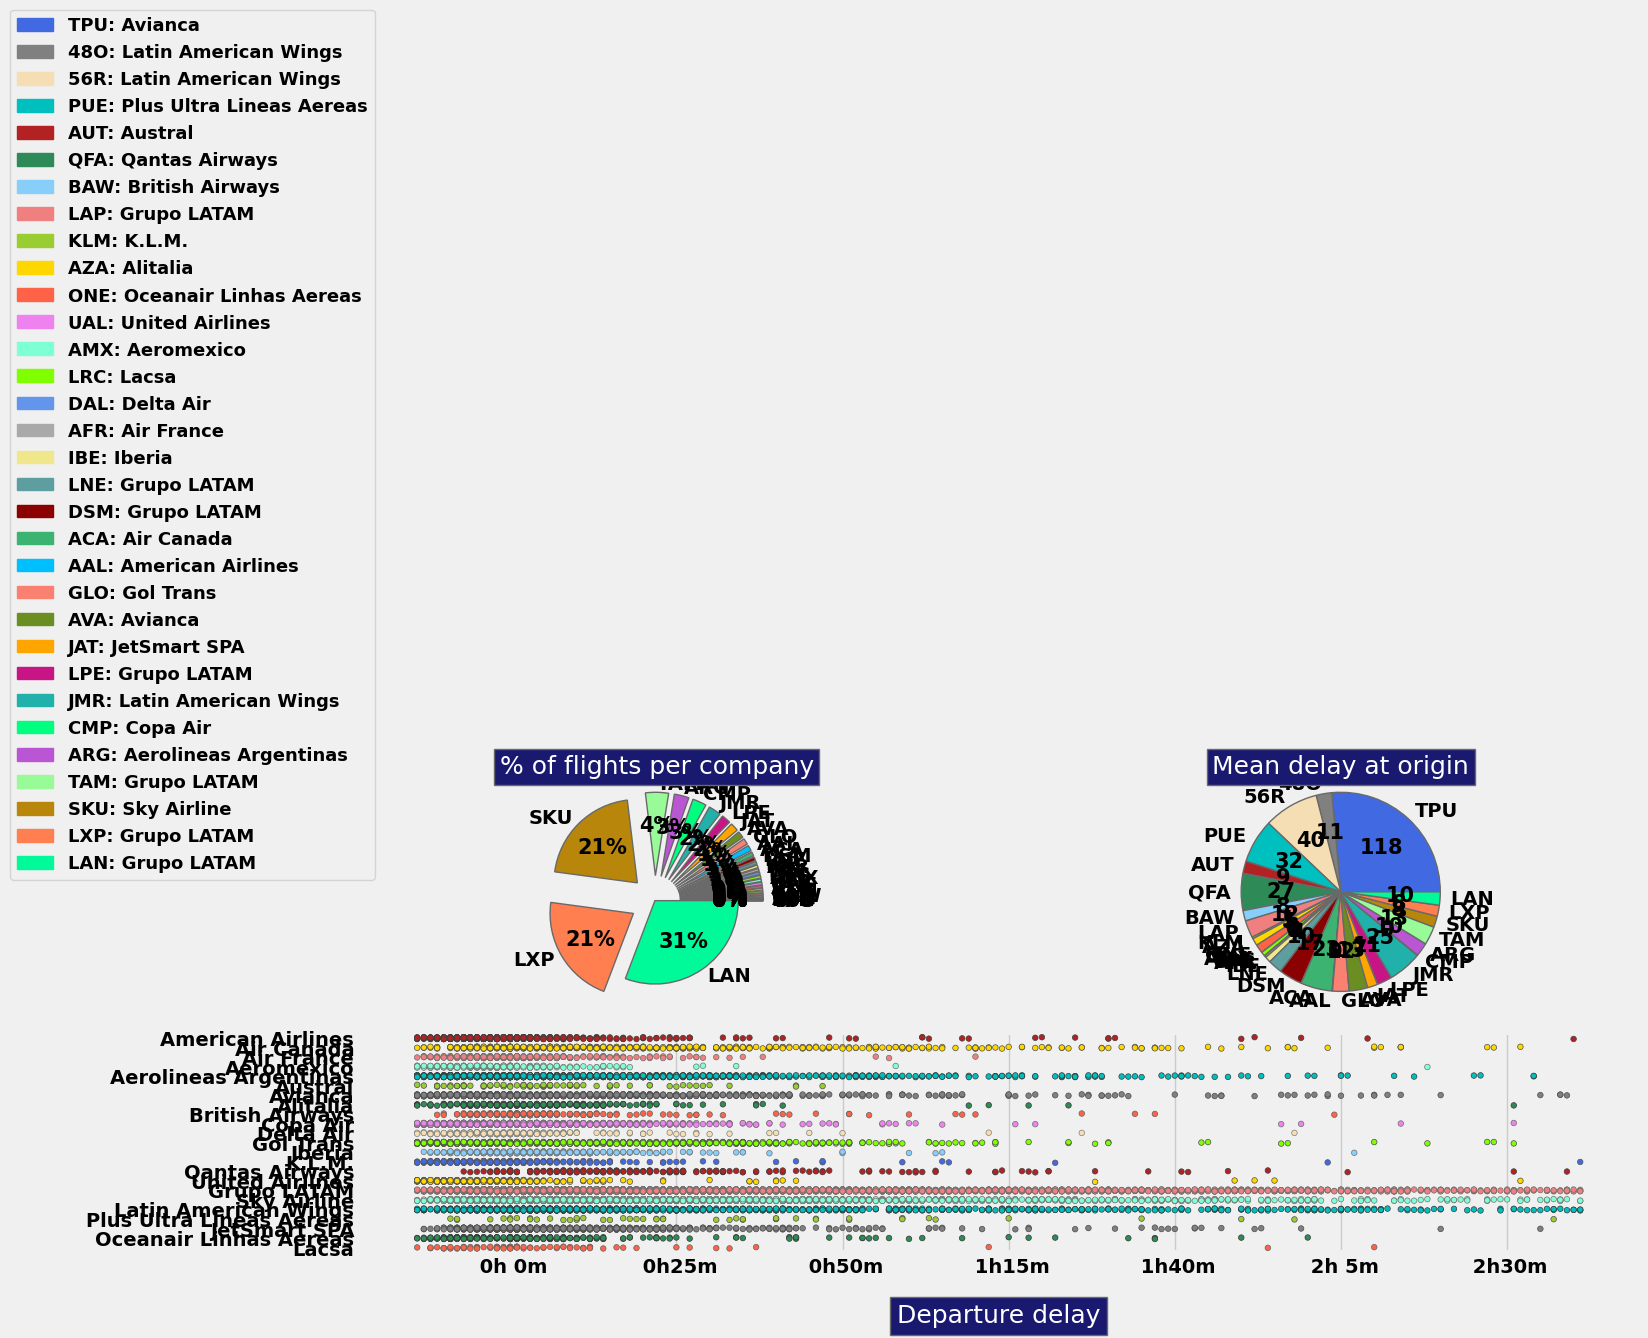

In [56]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['Emp-O', 'OPERA']]
df2['Emp-O'] = df2['OPERA'].replace(operadict)
df2['DELAY'] = df['DELAY']
# WE NEED 32 COLORS________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse',
          'cornflowerblue', 'darkgray', 'khaki', 'cadetblue', 'darkred', 'mediumseagreen', 'deepskyblue',
          'salmon', 'olivedrab', 'orange', 'mediumvioletred', 'lightseagreen', 'springgreen', 'mediumorchid',
          'palegreen', 'darkgoldenrod', 'coral', 'mediumspringgreen']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(operadict))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(operadict)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(operadict)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + operadict[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(operadict))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(operadict)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="OPERA", x="DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

we can see that we have too many airlines, so we will consider only the airlines operators that have >= 1% of the total flights

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

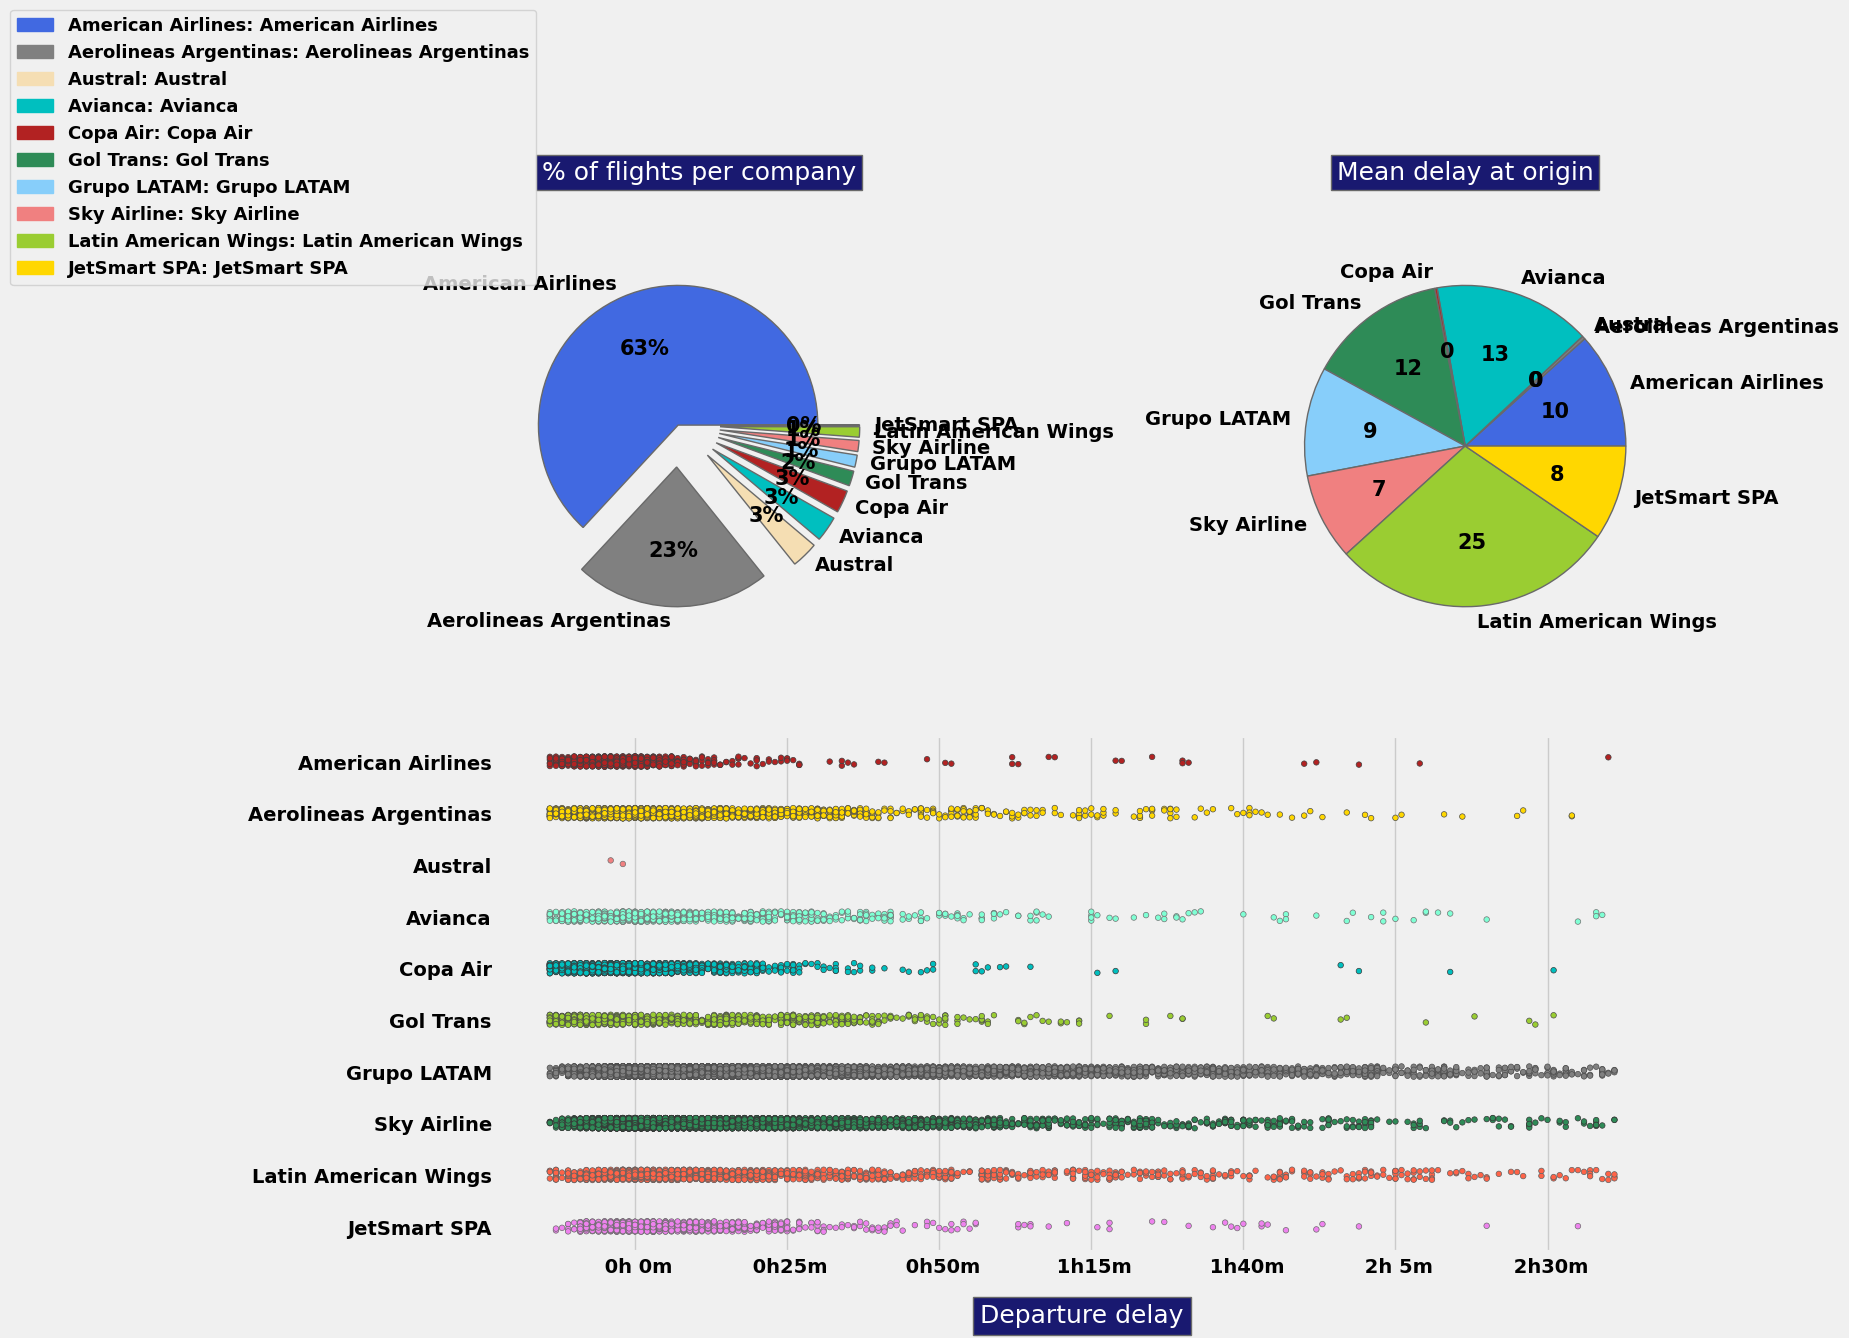

In [59]:
# Calculate the number of flights for each airline operator ('Emp-O') in 'df'
total_flights_per_operator = df['Emp-O'].value_counts()

# Calculate the percentage of total flights for each airline operator
percentage_of_flights_per_operator = total_flights_per_operator / len(df) * 100

# Filter the airline operators that have >= 1% of the total flights
operators_with_1_percent_or_more = percentage_of_flights_per_operator[percentage_of_flights_per_operator >= 1].index

# Filter the rows in 'df' to keep only the selected airline operators
df_filtered = df[df['Emp-O'].isin(operators_with_1_percent_or_more)]

# Create a dictionary of OPERA to Emp-O for the selected airline operators
operadict = dict(zip(df_filtered['Emp-O'], df_filtered['OPERA']))

# Redefine 'df2' using the filtered DataFrame
df2 = df_filtered.loc[:, ['Emp-O', 'OPERA']]
df2['Emp-O'] = df2['OPERA'].replace(operadict)
df2['DELAY'] = df_filtered['DELAY']

# WE NEED 32 COLORS________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse',
          'cornflowerblue', 'darkgray', 'khaki', 'cadetblue', 'darkred', 'mediumseagreen', 'deepskyblue',
          'salmon', 'olivedrab', 'orange', 'mediumvioletred', 'lightseagreen', 'springgreen', 'mediumorchid',
          'palegreen', 'darkgoldenrod', 'coral', 'mediumspringgreen']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
# Update the 'labels' and 'sizes' variables to reflect the filtered data in 'df2'
labels = [s for s in df2['Emp-O'].unique()]
sizes = df2['Emp-O'].value_counts().values
# Update the length of 'explode' based on the number of unique airline operators in df2
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(labels))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                labels=labels, colors=colors, autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(labels)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#_______________________________________________
# I set the legend: abbreviation -> airline name
comp_handler = []
for i in range(len(labels)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label=labels[i] + ': ' + df2[df2['Emp-O'] == labels[i]]['OPERA'].values[0]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize=13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes = df2.groupby('Emp-O')['DELAY'].mean().values
sizes = [max(s, 0) for s in sizes]
# Update the length of 'explode' based on the number of unique airline operators in df2
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(labels))]
patches, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels,
                                    colors=colors, shadow=False, startangle=0,
                                    autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(labels)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondence with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="OPERA", x="DELAY", size=4, palette=colors,
                    data=df2, linewidth=0.5, jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x, 60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)


if we have a look at the second pie chart, we see that here the differences among airlines are less pronounced about the mean of delay. Excluding the values in 0 that report extremely low mean delays, we obtain that a value of  ∼
 16 ± 9 minutes would correctly represent all mean delays.

Finally, the figure at the bottom makes a census of all the delays that were measured in 2017. This representation gives a feeling on the dispersion of data and put in perspective the relative homogeneity that appeared in the second pie chart. Indeed, we see that while all mean delays are around 10 minutes, this low value is a consequence of the fact that a majority of flights take off on time. However, we see that occasionally, we can face really large delays that can reach a few tens of hours !

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

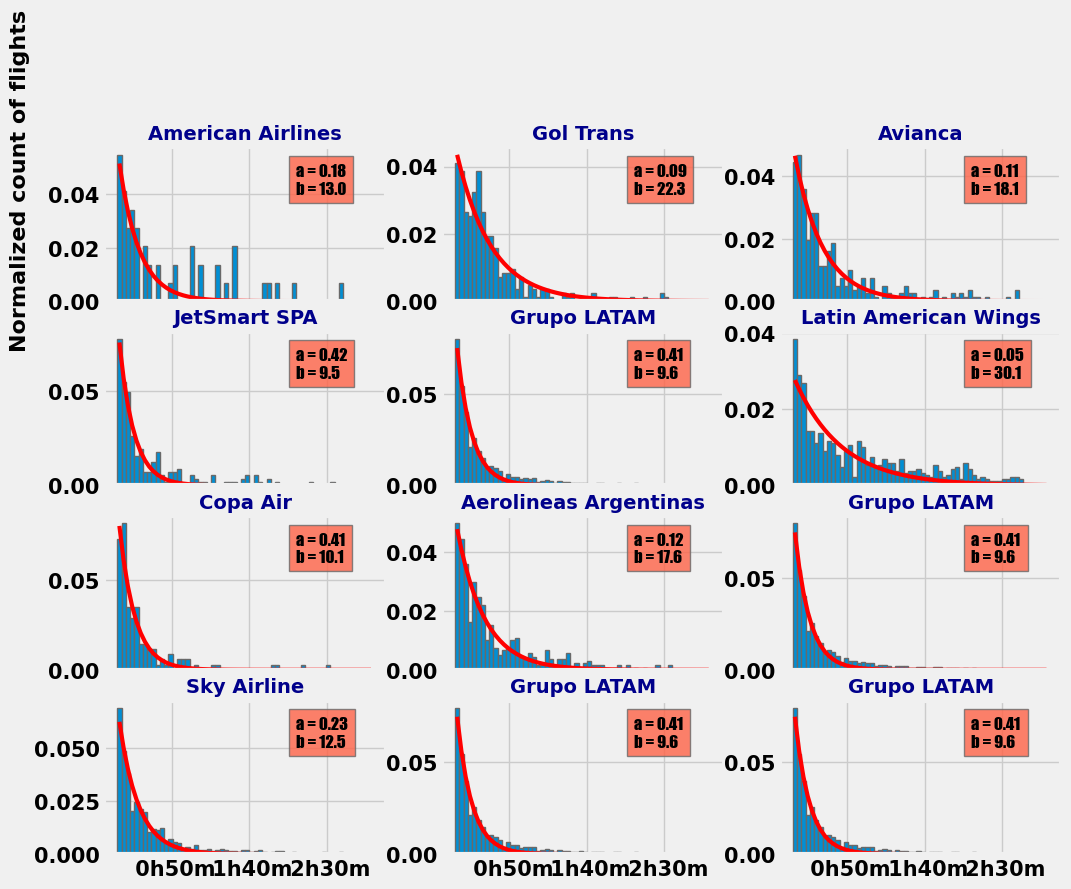

In [62]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [operadict[x] for x in global_stats.index if x in operadict]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x=df2[df2['OPERA'] == carrier_name]['DELAY'],
                                range=(15, 180), density=True, bins=60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0=[1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize=14, fontweight='bold', color='darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3, 0.9, 'Normalized count of flights', fontsize=16, rotation=90,
                color='k', horizontalalignment='center', transform=ax.transAxes)
    if i == 14:
        ax.text(0.5, -0.5, 'Delay at origin', fontsize=16, rotation=0,
                color='k', horizontalalignment='center', transform=ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0], 2), round(popt[1], 1)),
            style='italic', transform=ax.transAxes, fontsize=12, family='fantasy',
            bbox={'facecolor': 'tomato', 'alpha': 0.8, 'pad': 5})
    
plt.tight_layout()


## Challenge answers

1. 1 How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

R: we can see that Grupo LATAM has an negative exponential distribution:

f(x) = λ * exp(-λ * x)

where λ is the rate parameter (or scale parameter) of the distribution. In this case, λ is the reciprocal of the mean (λ = 1 / b) when the exponential distribution is parameterized with the scale parameter b. The mean of the exponential distribution is given by E(X) = 1 / λ.

Now we will add a boolean variable called "arrival" where the 1 means that is an arrival flight and 0 means a departure.

In [67]:
df['arrival'] = (df['SIGLAORI'] != 'Santiago').astype(int)
df['arrival'].unique()


array([0])

In [ ]:
#all the flights in the df are departures.

2. 2 Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:
○ high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
○ min_diff : difference in minutes between Date-O and Date-I .
○ delay_15 : 1 if min_diff > 15, 0 if not.
○ period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I .

In [85]:
df = pd.read_csv('C:/Users/ancaro/airlinedelay/dataset_SCL.csv', low_memory=False)
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [107]:
# Create a copy of the DataFrame to avoid modifying the original data
df_copy = df.copy()

# Convert 'Date-I' and 'Date-O' columns to datetime objects
df_copy['Fecha-I'] = pd.to_datetime(df_copy['Fecha-I'])
df_copy['Fecha-O'] = pd.to_datetime(df_copy['Fecha-O'])

# Define functions to compute additional columns
def high_season(date):
    return ((date.month == 12 and date.day >= 15) or
            (date.month == 3 and date.day <= 3) or
            (date.month == 7 and date.day >= 15) or
            (date.month == 7 and date.day <= 31) or
            (date.month == 9 and date.day >= 11) or
            (date.month == 9 and date.day <= 30))

def min_diff(row):
    return (row['Fecha-O'] - row['Fecha-I']).total_seconds() / 60

def delay_15(diff):
    return 1 if diff > 15 else 0

def period_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 19:
        return 'afternoon'
    else:
        return 'night'

# Apply the functions to create the new columns
df_copy['high_season'] = df_copy['Fecha-I'].apply(high_season)
df_copy['min_diff'] = df_copy.apply(min_diff, axis=1)
df_copy['delay_15'] = df_copy['min_diff'].apply(delay_15)
df_copy['period_day'] = df_copy['Fecha-I'].dt.hour.apply(period_day)

# Export the DataFrame to CSV file
df_copy.to_csv('synthetic_features.csv', index=False)
df_copy


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,False,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,False,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,False,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,False,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,False,-2.0,0,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,True,46.0,1,afternoon
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima,True,16.0,1,afternoon
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima,True,40.0,1,afternoon
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,True,13.0,0,afternoon


3. 3 What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?

Relationship airport destination with delay

Correlation between the delays registered and the airport of destination, how many they are?

In [103]:
operadict2 = dict(zip(df_copy['Emp-O'], df_copy['OPERA']))
len(operadict2)

32

In [108]:
print("Number of airports: {}".format(len(df_copy['SIGLADES'].unique())))

Number of airports: 62


In [105]:
destination_nb = dict()
for carrier in operadict2.keys():
    liste_dest_airport = df_copy[df_copy['Emp-O'] == carrier]['OPERA'].unique()
    destination_nb[carrier] = len(liste_dest_airport)

df_copy

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,False,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,False,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,False,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,False,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,False,-2.0,0,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,True,46.0,1,afternoon
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima,True,16.0,1,afternoon
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima,True,40.0,1,afternoon
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,True,13.0,0,afternoon


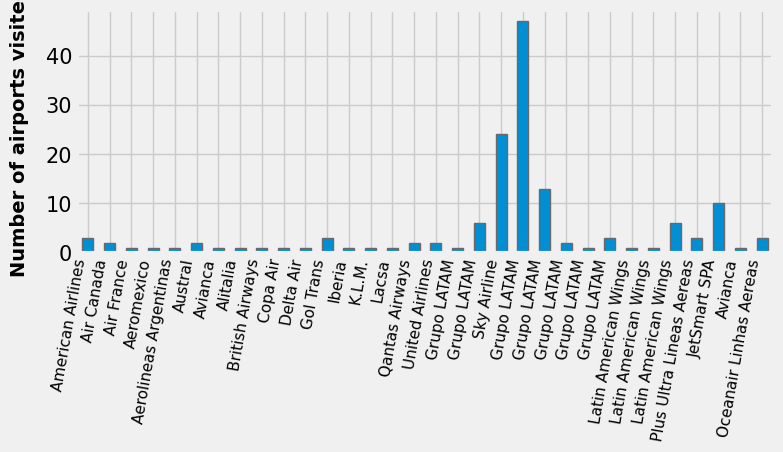

In [119]:
origin_nb = dict()
for carrier in operadict2.keys():
    liste_origin_airport = df_copy[df_copy['Emp-O'] == carrier]['SIGLADES'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [operadict2[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

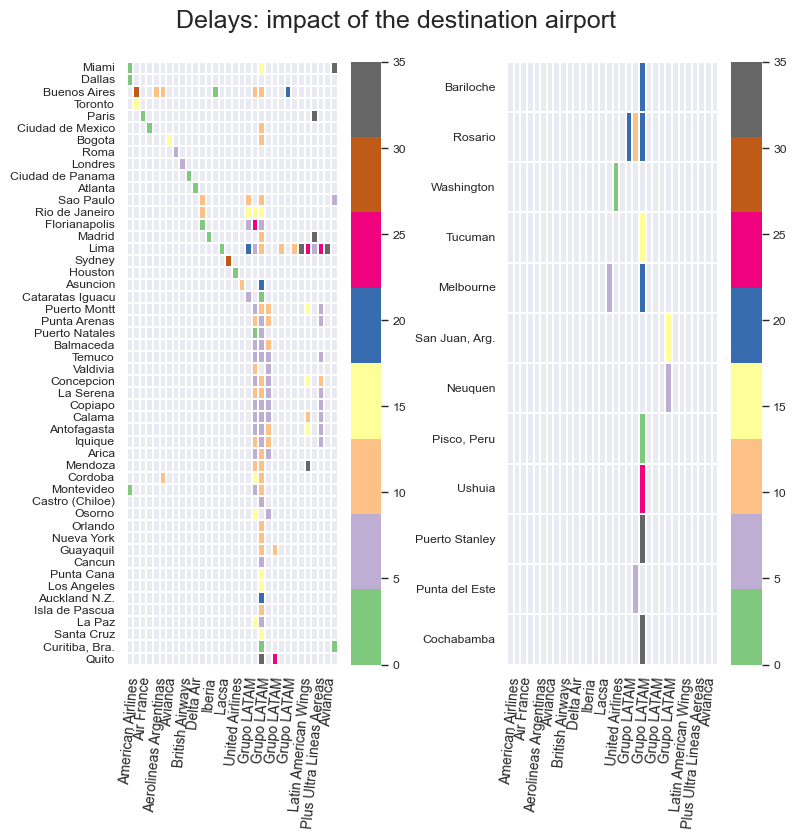

In [122]:
#we have a lot of different airports of destination, considering all the Grupo Latam accumulated frequencies
#how the destination impacts delay?

#lets see the variation of delay with respect destination airport
#first, lets view the mean of this by airport

airport_mean_delays = pd.DataFrame(pd.Series(df_copy['SIGLADES'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in operadict2.keys():
    df1 = df_copy[df_copy['Emp-O'] == carrier]
    test = df1['min_diff'].groupby(df['SIGLADES']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']  

sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = operadict2)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = operadict2)
fig.text(0.5, 1.02, "Delays: impact of the destination airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

Here we can see that Grupo Latam is associated with mainly 5 to 10 min delays with some severla delays greater than 20 minutes where all NATIONAL destination meets this parameter and in INTERNATIONAL.

with this, we can start figure how the model should be developed, becouse we meet a wide range in all airlines about the delay with respect to the flight destination.

So with this conclusion, we can use only the "Grupo Latam" data

Now we will see flights with usual delays of Latam Airlines

In [131]:
for emp_o, opera in operadict2.items():
    if opera == 'Grupo LATAM':
        print(f"Airline Operator ('Emp-O'): {emp_o}, Airline Name ('OPERA'): {opera}")

Airline Operator ('Emp-O'): LAP, Airline Name ('OPERA'): Grupo LATAM
Airline Operator ('Emp-O'): TAM, Airline Name ('OPERA'): Grupo LATAM
Airline Operator ('Emp-O'): LAN, Airline Name ('OPERA'): Grupo LATAM
Airline Operator ('Emp-O'): LXP, Airline Name ('OPERA'): Grupo LATAM
Airline Operator ('Emp-O'): LNE, Airline Name ('OPERA'): Grupo LATAM
Airline Operator ('Emp-O'): LPE, Airline Name ('OPERA'): Grupo LATAM
Airline Operator ('Emp-O'): DSM, Airline Name ('OPERA'): Grupo LATAM


In [156]:
# We select the company and create a subset of the main dataframe
carrier = ['LAP', "TAM", 'LAN', 'LXP', 'LNE', 'LPE', 'DSM']
df1 = df_copy[df_copy['Emp-O'].isin(carrier)][['SIGLAORI','SIGLADES','min_diff']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['min_diff']): continue
    route = str(col['SIGLAORI'])+'-'+str(col['SIGLADES'])
    if route in trajet.keys():
        trajet[route].append(col['min_diff'])
    else:
        trajet[route] = [col['min_diff']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()


now we calculate the avarage delay by destionation with the standard deviation and make a candle graph to represent this

In [146]:
df1

,SIGLAORI,SIGLADES,min_diff
895,Santiago,Asuncion,15.0
896,Santiago,Asuncion,5.0
897,Santiago,Asuncion,9.0
898,Santiago,Asuncion,8.0
899,Santiago,Asuncion,33.0
...,...,...,...
67693,Santiago,La Serena,4.0
67694,Santiago,Antofagasta,25.0
67695,Santiago,Florianapolis,28.0
67696,Santiago,Concepcion,-1.0


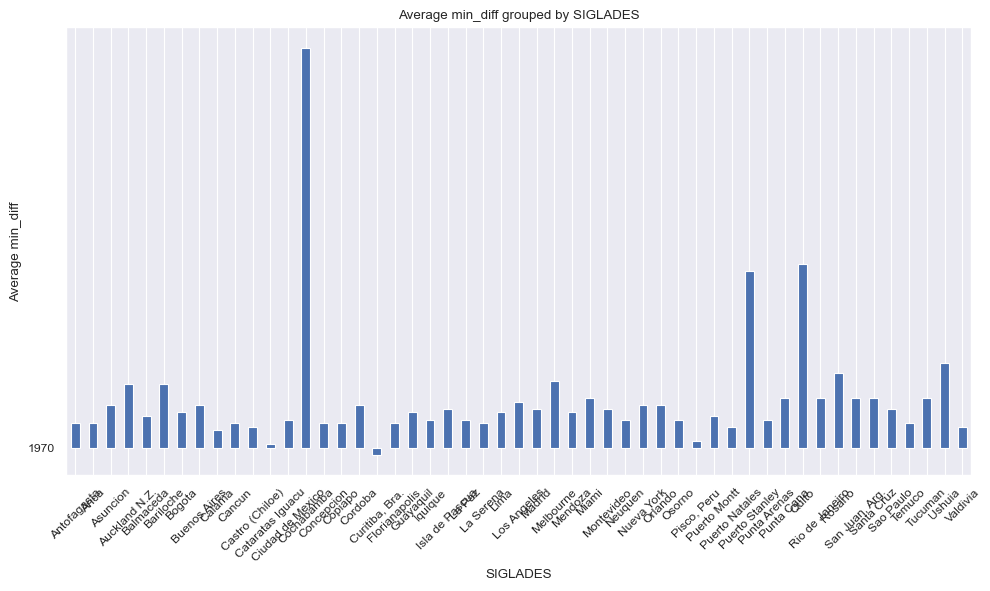

In [154]:
average_min_diff = df1["min_diff"].mean()
std_min_diff = df1["min_diff"].std()

# Group the data by "SIGLADES" and calculate the average for each group
grouped_data = df1.groupby("SIGLADES")["min_diff"].mean()

# Plot the grouped data using a bar chart
plt.figure(figsize=(10, 6))
grouped_data.plot(kind="bar")
plt.title("Average min_diff grouped by SIGLADES")
plt.xlabel("SIGLADES")
plt.ylabel("Average min_diff")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

We see that we have a great deviation of the minutes of delay in particular international and national destination like Puerto Natales for national, and international, cataratas iguacu

Modeling

4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables.
5. Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used
to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in
the prediction task? How could you improve the
Performance?

For this, we will take the >= 15 minutes of delay that is considered "delayed", for this, we will add a a column that will show 1 if the delay time is greater than 15 minutes and 0 if the delay is in the df_copy[]

In [160]:
df_copy.value_counts('delay_15')

delay_15
0    55592
1    12614
dtype: int64

In [ ]:
# we will drop non-numerical columns

In [161]:
print(df_copy.dtypes)

Fecha-I        datetime64[ns]
Vlo-I                  object
Ori-I                  object
Des-I                  object
Emp-I                  object
Fecha-O        datetime64[ns]
Vlo-O                  object
Ori-O                  object
Des-O                  object
Emp-O                  object
DIA                     int64
MES                     int64
AÑO                     int64
DIANOM                 object
TIPOVUELO              object
OPERA                  object
SIGLAORI               object
SIGLADES               object
high_season              bool
min_diff              float64
delay_15                int64
period_day             object
dtype: object


In [165]:
df_copy

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,False,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,False,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,False,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,False,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,False,-2.0,0,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,True,46.0,1,afternoon
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima,True,16.0,1,afternoon
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima,True,40.0,1,afternoon
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima,True,13.0,0,afternoon


In [167]:
# and you want to drop the specified columns
columns_to_drop = ['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O', 'DIANOM',
                   'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES', 'period_day', 'high_season']

# Create a copy of the DataFrame with specified columns dropped
df_copy = df_copy.drop(columns=columns_to_drop)

# Display the updated DataFrame
print(df_copy)



KeyError: "['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES', 'period_day'] not found in axis"

In [174]:
# Check if the 'high_season' column exists in the DataFrame
if 'high_season' in df_copy.columns:
    # Drop the 'high_season' column if it exists
    df_copy = df_copy.drop('high_season', axis=1)

# Display the updated DataFrame
print(df_copy)


       DIA  MES   AÑO  min_diff  delay_15
0        1    1  2017       3.0         0
1        2    1  2017       9.0         0
2        3    1  2017       9.0         0
3        4    1  2017       3.0         0
4        5    1  2017      -2.0         0
...    ...  ...   ...       ...       ...
68201   22   12  2017      46.0         1
68202   25   12  2017      16.0         1
68203   27   12  2017      40.0         1
68204   29   12  2017      13.0         0
68205   31   12  2017       9.0         0

[68206 rows x 5 columns]


In [176]:
data = df_copy.values
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)  # splitting in the ratio 70:30

In [177]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [180]:
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [181]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob[:,1])
auc_score

1.0

this auc roc is strange, so I will reevaluate the split train test data, cross validation, overfitting